### Данные - Ирисы Фишера

В задаче будет рассмотрена реальная выборка - ирисы Фишера, по 3 и 4 признаку, т.е. petalLength и petalWidth.

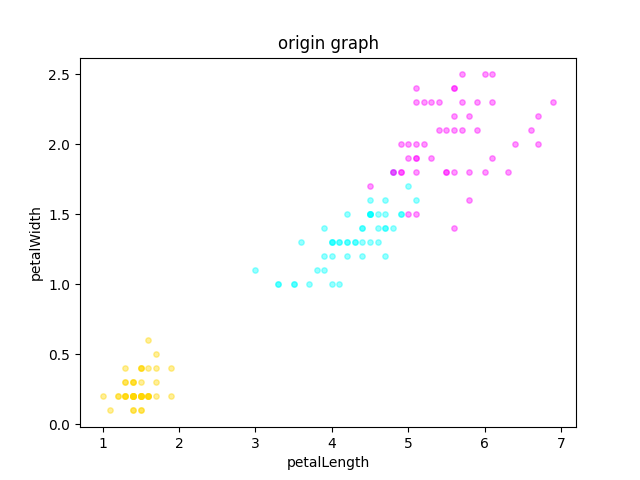


### Описание алгоритма

Предположим, что множество объектов X и множество классов Y таковы, что множество X $\times$ Y является вероятностным пространтсвом с плотностью распределения: $p(x,y) =$ P$(y) * p(x|y)$ , где первый множитель - априорная вероятность класса, а второй вероятность объекта принадлежать классу. 

$p(x|y) = p_y (x)$ - функции правдоподобия классов.

Функционалом среднего риска нызвают величину потери при классификации объектов алгоритмом $a$:

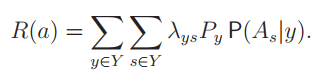

Вероятность события P$(A_s | y)$, т.е. $x \in A_s$ при условии, что $x \in y$, может быть найдена при помощи функций правдоподобия. В общем виде это интеграл (сумма) функций правдоподобия для каждого элемента из $A_s$.



Оптимальное байесовское решающее правило гласит о том, что если известны априорные вероятности классов и функции правдоподобия, то минимум среднего риска достигается алгоритмом:

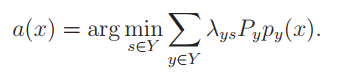

Предположим теперь, что все признаки объекта являются независимыми случайными величинами. Тогда функции правдоподобия классов могут быть представленны как произведение плотностей распределения значений каждого признака. Исходя из такой гипотезы представим алгоритм в новом виде:

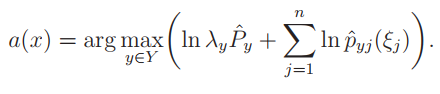

Предположим теперь, что вероятностное распределение задано с точностью до некоторого параметра $θ : \varphi(x, θ)$. Тогда функцией правдоподобия называется совместная плотность распределений всех объектов выборки: 

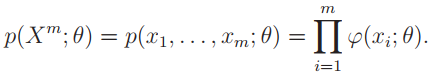

Максимизируя функцию правдоподобия по параметру θ производится оценка максимума правдоподобия. Т. е. находится такое θ, при котором выборка максимально правдоподобна.

Вместо максимизации функции правдоподобия удобнее максимизировать ее логарифм:

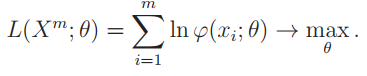

Пусть $\varphi \equiv \mathcal{N}(μ,Σ)$, тогда параметрами выступает среднее и ковариационная матрица: $θ = (μ, Σ)$. Оценки, доставляющие максимум функционалу правдоподобия имеет вид:

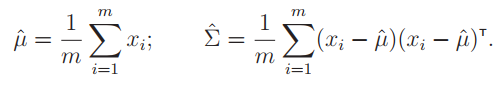

Если в качестве плотностей распределения признаков взять нормальное распределение, то получим наивный нормальный байесовский классификатор.

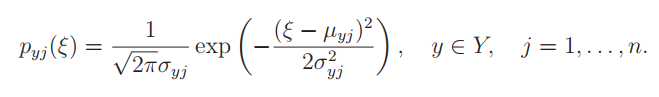

### Код программы

Классы, которые основаные на вышеизложенных положениях имеют одного общего абстрактного класса предка.

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd


class AbstractDisc(ABC):
    _objects: list
    _answers: list
    answer_set: list

    cases_count: int
    component_count: int

    classes_errors: dict
    cases_by_classes: dict
    classes_probabilities: dict

    centers: dict
    covariance: dict

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, cl_errors: dict = None, is_column_name=True):
        if is_column_name:
            objects.columns = objects.iloc[0]
            answers.columns = answers.iloc[0]
        self.objects = objects
        self.answers = answers
        if cl_errors is None:
            self.classes_errors = dict()
            for y in self.answer_set:
                self.classes_errors[y] = 1
        self.component_count = len(self.objects[0][1])
        self.cases_count = len(self.objects)
        self.cases_by_classes_init()
        self.classes_probabilities_init()

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, val):
        self._objects = []
        for index, obj in val.iterrows():
            self._objects.append((index, np.array(obj)))

    @property
    def answers(self):
        return self._answers

    @answers.setter
    def answers(self, val):
        self._answers = []
        for _, answer in val.iterrows():
            self._answers.append(answer.tolist()[0])
        # Формирование упорядоченого множества
        self.answer_set = list(dict.fromkeys(self._answers))

    def cases_by_classes_init(self):
        self.cases_by_classes = dict.fromkeys(self.answer_set)

        for key in self.cases_by_classes:
            self.cases_by_classes[key] = dict()

        for x in self.objects:
            y = self.answers[x[0]]
            self.cases_by_classes[y][x[0]] = x

    def classes_probabilities_init(self):
        self.classes_probabilities = dict()
        for y in self.answer_set:
            self.classes_probabilities[y] = float(len(self.cases_by_classes[y])) / self.cases_count

    @abstractmethod
    def centers_init(self, *args):
        pass

    @abstractmethod
    def covariance_init(self, *args):
        pass

    @abstractmethod
    def gamma(self, x, y):
        pass

    def classify(self, x, is_new_element=True, *args):
        if not is_new_element:
            x = x[1]

        max_gamma = None
        arg_max = None
        for y in self.answer_set:
            gamma = self.gamma(x, y)
            if max_gamma is None or gamma > max_gamma:
                max_gamma = gamma
                arg_max = y
        return arg_max
        
    def error(self):
        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
        return incorrect_object_answer / self.cases_count

Класс, реализующий наивный нормальный бейесовский классификатор представлен ниже. 

In [ ]:
import numpy as np
import pandas as pd
import nd_normal_distribution as ndn


class NaiveBayes(AbstractDisc):
    cl_cases_probabilities: dict

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, cl_errors: dict = None, is_column_name=True):
        super().__init__(objects, answers, cl_errors, is_column_name)
        self.centers_init()
        self.covariance_init()
        self.cl_cases_probabilities_init()

    def centers_init(self):
        self.centers = dict()
        for y in self.answer_set:
            self.centers[y] = []

        for y in self.answer_set:
            for j in range(self.component_count):
                res = 0
                m = self.cases_by_classes[y].keys()
                for i in m:
                    x = self.cases_by_classes[y][i][1][j]
                    res += x
                self.centers[y].append(res / len(m))

    def covariance_init(self):
        self.covariance = dict()
        for y in self.answer_set:
            self.covariance[y] = []

        for y in self.answer_set:
            for j in range(self.component_count):
                res = 0
                m = self.cases_by_classes[y].keys()
                for i in m:
                    x = self.cases_by_classes[y][i][1][j] - self.centers[y][j]
                    res += x * x
                self.covariance[y].append(res / len(m))

    def cl_cases_probabilities_init(self):
        self.cl_cases_probabilities = dict()
        for y in self.answer_set:
            self.cl_cases_probabilities[y] = []

        for y in self.answer_set:
            for j in range(self.component_count):
                self.cl_cases_probabilities[y]\
                    .append(ndn.NDimensionalNormalDistribution(self.covariance[y][j],
                                                               self.centers[y][j]))

    def probability(self, x, y, j):
        return self.cl_cases_probabilities[y][j].probability(x)

    def gamma(self, x, y):
        res = np.log(self.classes_errors[y] * self.classes_probabilities[y])
        for j in range(self.component_count):
            res += self.probability(x[j], y, j)
        return res

### Результаты

Карта классификации:

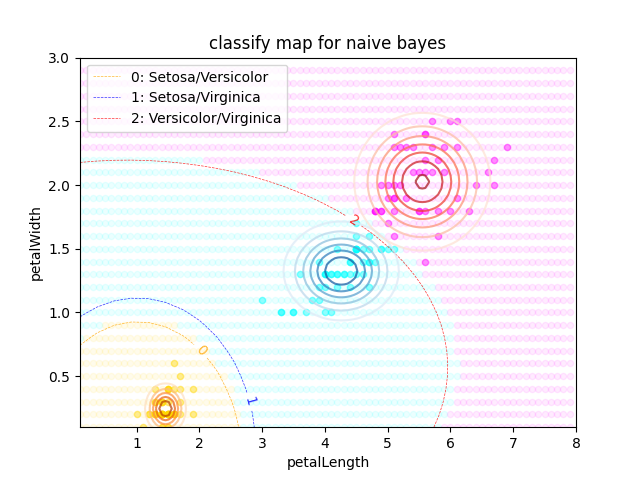

В качестве разделяющих кривых выступают эллипсы.

Ошибка классификации составляет 1/25